## Test the pretrained model's predictions on some noisy voices.

We are using this model: https://github.com/vbelz/Speech-enhancement

In [2]:
# constants (defined in the repo)
SAMPLE_RATE = 8000
MIN_DURATION = 1.0
FRAME_LENGTH = 8064
HOP_LENGTH_FRAME = 8064
HOP_LENGTH_FRAME_NOISE = 5000
N_FFT = 255
HOP_LENGTH_FFT = 63
DIM_SQUARE_SPEC = int(N_FFT / 2) + 1

### Step 1: Run the pretrained model on a single example and check the reconstruction.

In [3]:
from IPython import display
example_audio = "D:/for-norm/training/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
display.display(display.Audio(example_audio, rate=SAMPLE_RATE))

In [4]:
import librosa
waveform, _ = librosa.load(example_audio, sr=SAMPLE_RATE)
waveform.shape

(20013,)

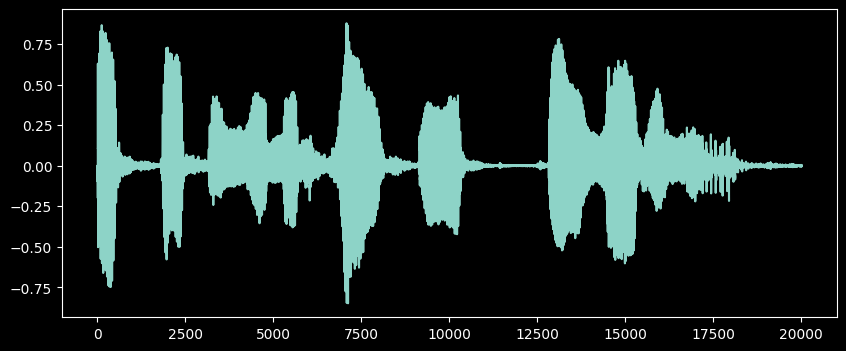

In [5]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.figure(figsize=(10, 4))
plt.plot(waveform)
plt.show()

In [6]:
with open("weights/model_unet.json", "r") as json_file:
    loaded_model_json = json_file.read()

In [7]:
import tensorflow as tf
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_46 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_48[0][0]']              
                                )                                                           

In [21]:
import denoising_AE as DAE

In [22]:
# loading audio with my function
audio = DAE.single_audio_file_to_numpy(example_audio, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
audio.shape

(2, 8064)

In [23]:
# loading audio as authors did (prob a better idea)
# start by predicting on training data, we can evaluate on validation/test later
real_audio_dir_prediction = "D:/for-norm/training/real"; fake_audio_dir_prediction = "D:/for-norm/training/fake"
real_audio_prediction = "file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"; fake_audio_prediction = "file1000.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav"

real_audio = DAE.audio_files_to_numpy(real_audio_dir_prediction, real_audio_prediction, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
fake_audio = DAE.audio_files_to_numpy(fake_audio_dir_prediction, fake_audio_prediction, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)

real_audio.shape, fake_audio.shape # the first fake example is short so the preprocessing will cut it off

((2, 8064), (1, 0))

In [24]:
m_amp_db_audio, m_pha_audio = DAE.numpy_audio_to_matrix_spectrogram(real_audio, DIM_SQUARE_SPEC, N_FFT, HOP_LENGTH_FFT)
m_amp_db_audio.shape, m_pha_audio.shape

((2, 128, 128), (2, 128, 128))

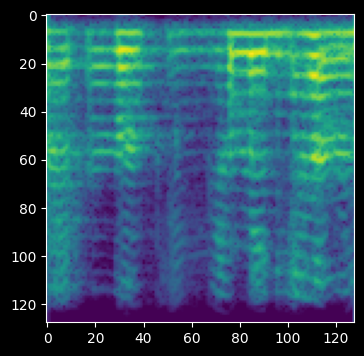

In [55]:
# which combination of axes is the actual spectrogram?
# it's definitely not the phase part since that has complex numbers
# try diff combos of the m_amp_db thing
display_spec = m_amp_db_audio[1] + m_amp_db_audio[0]

plt.figure(figsize=(10, 4))
plt.imshow(display_spec)

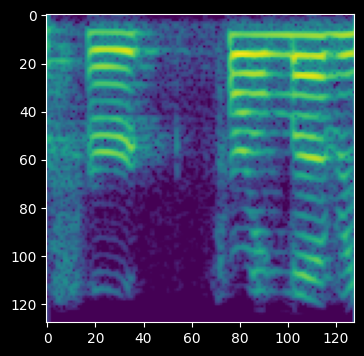

In [25]:
plt.figure(figsize=(10, 4))
plt.imshow(m_amp_db_audio[1])

In [26]:
# global scaling to have distribution -1/1
X_in = DAE.scaled_in(m_amp_db_audio)
#Reshape for prediction
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
#Prediction using loaded network
X_pred = loaded_model.predict(X_in)

#Rescale back the noise model
inv_sca_X_pred = DAE.inv_scaled_ou(X_pred)
#Remove noise model from noisy speech
X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
#Reconstruct audio from denoised spectrogram and phase
audio_denoise_recons = DAE.matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, FRAME_LENGTH, HOP_LENGTH_FFT)
#Number of frames
nb_samples = audio_denoise_recons.shape[0]

1/1 [==============================] - 0s 65ms/step


In [27]:
audio_denoise_recons.shape

(2, 8064)

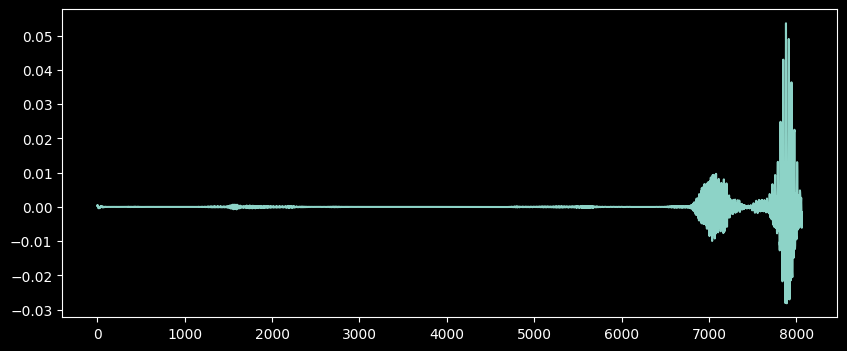

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(audio_denoise_recons[1])
plt.show()

In [29]:
display.display(display.Audio(audio_denoise_recons[1], rate=SAMPLE_RATE))

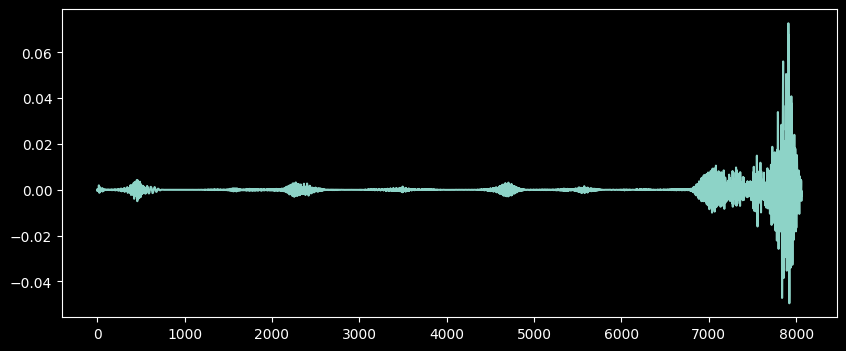

In [30]:
recons_sum = audio_denoise_recons[0] + audio_denoise_recons[1]
plt.figure(figsize=(10, 4))
plt.plot(recons_sum)
plt.show()

In [31]:
display.display(display.Audio(recons_sum, rate=SAMPLE_RATE))

In [19]:
# calculate the reconstruction error
# this function has been added to the denoising AE file
import numpy as np
def calculate_reconstruction_error(x, x_hat):
    """
    Returns the reconstruction error between two data points x and x_hat.
    We will use the MSE as the reconstruction error in our case.
    """
    error = np.square(x - x_hat).mean()
    return error

(20013,)


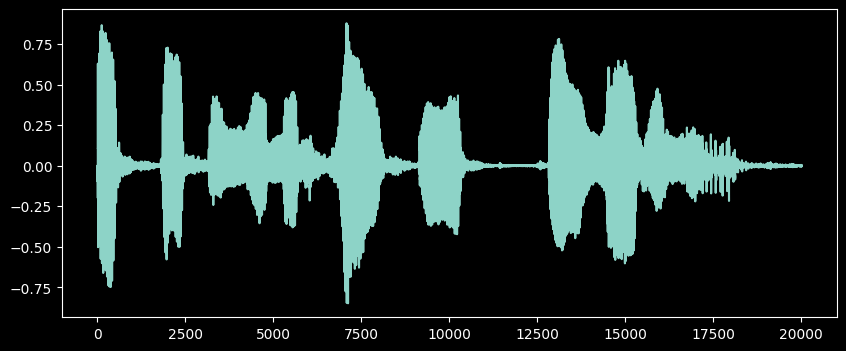

In [42]:
# need to figure out which component of the processed audio is the actual audio
# the original audio is the "waveform" variable, and the preprocessed version is the "real audio"
# plot and play both
print(waveform.shape)
plt.figure(figsize=(10, 4))
plt.plot(waveform)
plt.show()

display.display(display.Audio(waveform, rate=SAMPLE_RATE))

(16128,)


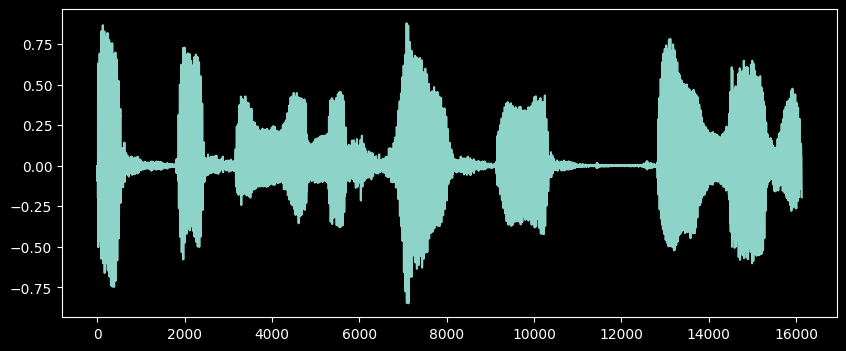

In [43]:
# so we know that the input sample is the real audio.
# which channel is the actual waveform???
# could be real_audio, real_audio[0], [1], or [0] + [1], or [[0], [1]]
# use the concatenate thing
display_audio = np.concatenate((real_audio[0], real_audio[1]))
print(display_audio.shape)

plt.figure(figsize=(10, 4))
plt.plot(display_audio)
plt.show()

display.display(display.Audio(display_audio, rate=SAMPLE_RATE))

(16128,)


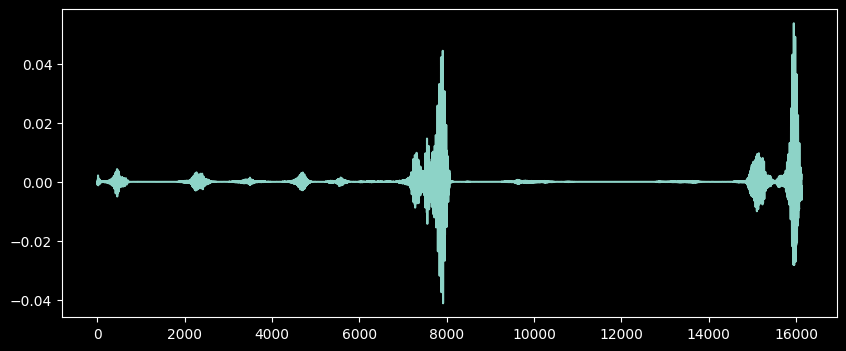

In [45]:
# let's do the same with the prediction
full_recons = np.concatenate((audio_denoise_recons[0], audio_denoise_recons[1]))
print(full_recons.shape)

plt.figure(figsize=(10, 4))
plt.plot(full_recons)
plt.show()

display.display(display.Audio(full_recons, rate=SAMPLE_RATE))

In [46]:
calculate_reconstruction_error(display_audio, full_recons)

0.024048634126999716

### Let's package all this up into functions to make it easier to test.

We can add these functions to the Python file.

In [87]:
def load_pretrained_model(display_summary=False):
    """
    Loads the pretrained model from a .json file and optionally displays a summary.
    """
    with open("weights/model_unet.json", "r") as json_file: loaded_model_json = json_file.read()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    if display_summary: loaded_model.summary()
    return loaded_model

def predict_with_model(model, audio_path, display_output=False, add_noise=False):
    """
    Makes a prediction on a single audio file with the model and optionally displays some output.
    The output will include the waveforms, spectrograms, and audio clips for the original and reconstructed audio.
    We will also report the reconstruction loss (MSE) between the original and reconstructed spectrograms and waveforms. 
    """
    # loading audio into waveform as authors did
    audio_dir = "/".join(audio_path.split("/")[0:4])
    audio_pred = audio_path.split("/")[-1]
    audio = DAE.audio_files_to_numpy(audio_dir, audio_pred, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)

    # add some noise to the audio
    

    # convert to spectrogram as the authors did
    amp_db_audio, pha_audio = DAE.numpy_audio_to_matrix_spectrogram(audio, DIM_SQUARE_SPEC, N_FFT, HOP_LENGTH_FFT)

    # make prediction (reconstruct) on the input spectrogram as the authors did
    X_in = DAE.scaled_in(amp_db_audio)
    X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
    X_pred = model.predict(X_in)

    # denoise the prediction (X_denoise is the reconstruced & denoised spectrogram)
    inv_sca_X_pred = DAE.inv_scaled_ou(X_pred)
    X_denoise = amp_db_audio - inv_sca_X_pred[:,:,:,0]

    # convert the spectrogram to the reconstructed and denoised audio
    audio_denoise_recons = DAE.matrix_spectrogram_to_numpy_audio(X_denoise, pha_audio, FRAME_LENGTH, HOP_LENGTH_FFT)

    # convert the waveforms and spectrograms to correct shape for display and reconstruction errors
    wav_in = np.concatenate((audio[0], audio[1]))
    wav_out = np.concatenate((audio_denoise_recons[0], audio_denoise_recons[1]))
    spect_in_squeeze = np.squeeze(X_in)
    spect_in = spect_in_squeeze[0] + spect_in_squeeze[1]
    spect_out = X_denoise[0] + X_denoise[1]
    
    # calculate reconstruction errors for spectrogram and waveform
    spect_error = calculate_reconstruction_error(spect_in, spect_out)
    wav_error = calculate_reconstruction_error(wav_in, wav_out)

    # display any possible output
    if display_output:

        # error
        print(f"SPECTROGRAM RECONSTRUCTION ERROR: {spect_error}")
        print(f"WAVEFORM RECONSTRUCTION ERROR: {wav_error}")

        # audio
        print("original audio:")
        display.display(display.Audio(wav_in, rate=SAMPLE_RATE))
        print("reconstructed audio:")
        display.display(display.Audio(wav_out, rate=SAMPLE_RATE))

        # plots
        fig, axs = plt.subplots(2, 2, figsize=(20, 7))
        fig.suptitle("displaying original and reconstructed audios and spectrograms (row 1 = original)")
        axs[0, 0].plot(wav_in)
        axs[0, 1].imshow(spect_in)
        axs[1, 0].plot(wav_out)
        axs[1, 1].imshow(spect_out)

1/1 [==============================] - 0s 246ms/step
SPECTROGRAM RECONSTRUCTION ERROR: 4800.151583357433
WAVEFORM RECONSTRUCTION ERROR: 22.05551307628129
original audio:


reconstructed audio:


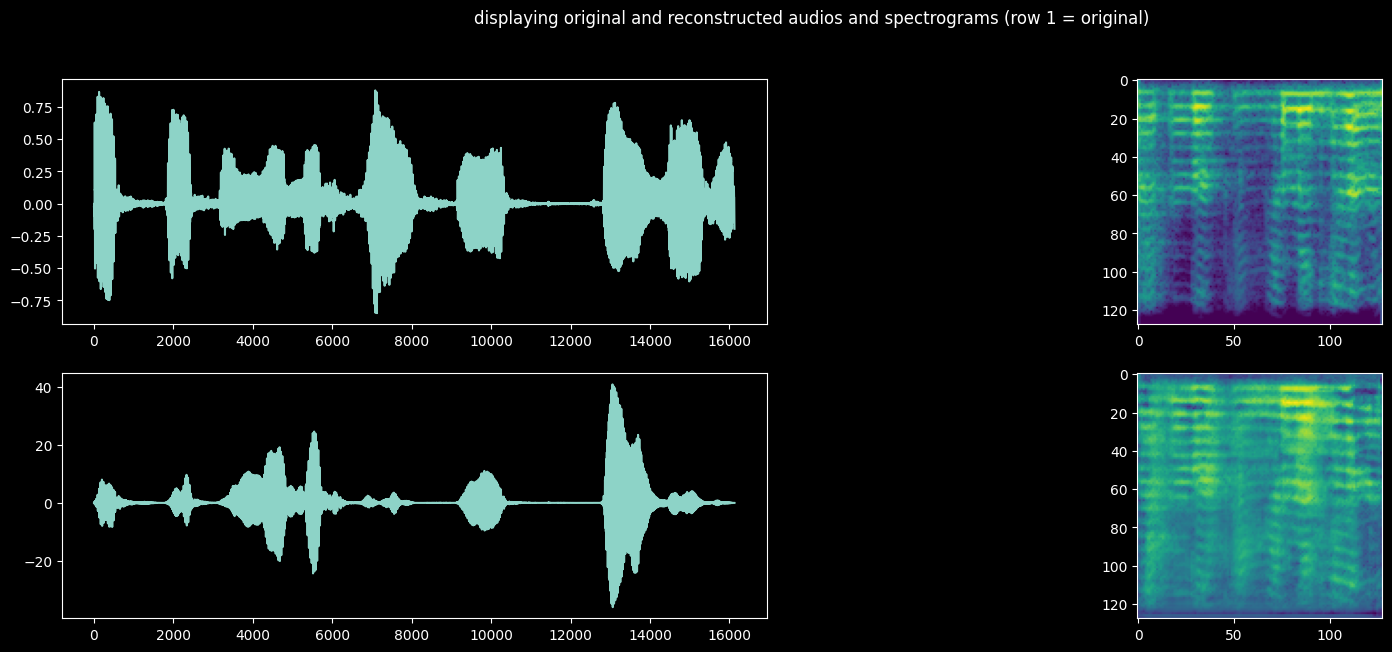

In [88]:
m = load_pretrained_model()
example_audio = "D:/for-norm/training/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predict_with_model(m, example_audio, display_output=True)

### Next, let's try adding some noise to the audio and passing that into the prediction function.